In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.04430762/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# c1

## Column density ratios

In [14]:
logN_dict = {'HI':'14.9, -0.1, +0.2',
            'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            'NIV':'13.01, -0.09, +0.09',
            'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV':'13.97, -0.03, +0.03',
            'OVI':'13.7, -0.2, +0.2',
            'NeV':'<14.0',
            'MgII':'<11.3',
            'MgX':'<13.6',
            'AlII':'<11.1',
            'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',
            'FeII':'<11.6',}

In [15]:
gen_logN_ratio_str(logN_dict['OIV'], logN_dict['HI'])

'-0.40, -0.22, 0.14'

In [16]:
logN_ratio_dict = {'OIV/OIII': '0.10, -0.14, 0.14',
                   'OVI/OV': '-0.27, -0.20, 0.20',
                  'CIV/CIII': '-0.36, -0.60, 0.50'}

(-2.2, 2.5)

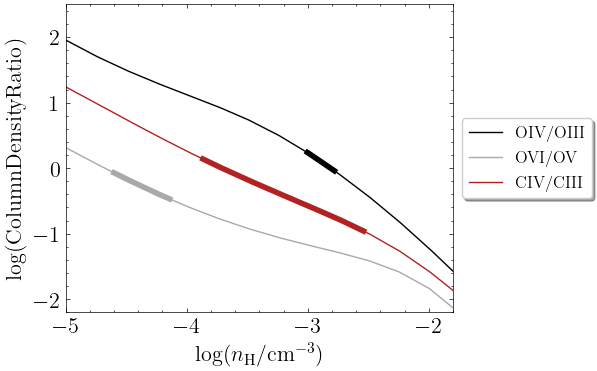

In [17]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2.5)

In [18]:
logN_ratio_dict = {'OIV/OIII': '-5.0, -0.14, 0.14',
                   'OVI/OV': '-5.0, -0.20, 0.20',
                   }

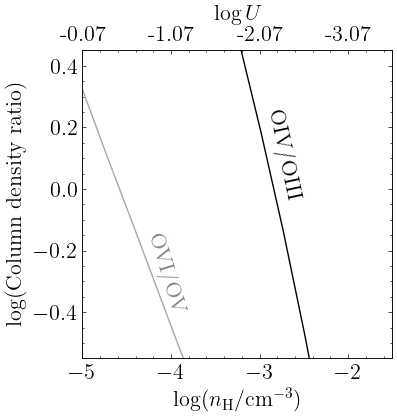

In [19]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-1.0)

ax.text(-2.95, -0.03, 'OIV/OIII', rotation=-78)
ax.text(-4.3, -0.4, 'OVI/OV', color='gray',rotation=-73)


ax_copy = ax.twiny()
ax_copy.set_xticks([-5, -4, -3, -2],[-0.07,-1.07,-2.07,-3.07])


ax.set_xlim(-5.0, -1.5)
ax_copy.set_xlim(-5.0, -1.5)

ax.set_ylim(-.55, .45)

ax_copy.set_xlabel(r'$\log U$')
ax.set_ylabel(r'log(Column density ratio)')

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Figures/z_104_oxy_ratios_model.png', dpi=300)

In [20]:
logN_ratio_dict = {'OIV/OIII': '0.10, -0.14, 0.14',
                   'OVI/OV': '-0.27, -0.20, 0.20',}

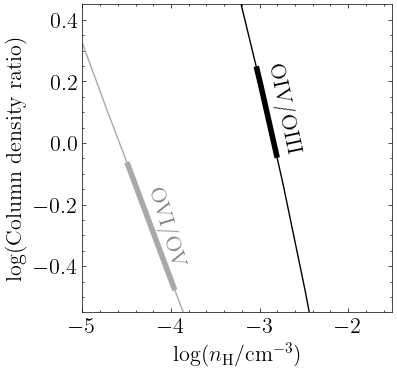

In [21]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-1.)

ax.text(-2.95, -0.03, 'OIV/OIII', rotation=-78)
ax.text(-4.3, -0.4, 'OVI/OV', color='gray',rotation=-73)


#ax_copy = ax.twiny()
#ax_copy.set_xticks([-5, -4, -3, -2],[-0.07,-1.07,-2.07,-3.07])


ax.set_xlim(-5.0, -1.5)
#ax_copy.set_xlim(-5.0, -1.5)

ax.set_ylim(-.55, .45)

ax.set_ylabel(r'log(Column density ratio)')

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Figures/z_104_oxy_ratios_obs.png', dpi=300)

In [22]:
logN_ratio_dict = {'CIV/OIV': '+0.86, -0.11, 0.11'
                   }

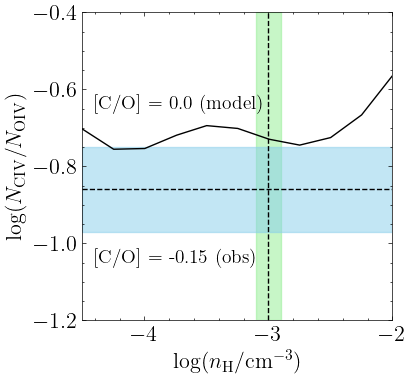

In [23]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-1.)

ax.text(-4.4, -0.65, r'[C/O] = 0.0 (model)', fontsize=14)
ax.axvline(-3.0, color='black', linestyle='--')
ax.axvspan(-3.0-0.1,-3.0+0.1, color='lightgreen', alpha=.5)

ax.axhline(-0.86, color='black', linestyle='--')
ax.text(-4.4, -1.05, r'[C/O] = -0.15 (obs)', fontsize=14)

ax.axhspan(-0.86-0.11,-0.86+0.11, color='skyblue', alpha=.5)

ax.set_xlim(-4.5, -2.)

ax.set_ylim(-1.2, -.4)

ax.set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$')

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Figures/z_104_C_O.png', dpi=300)

In [24]:
logN_ratio_dict = {'OIV/HI': '+0.40, -0.22, 0.14'
                   }

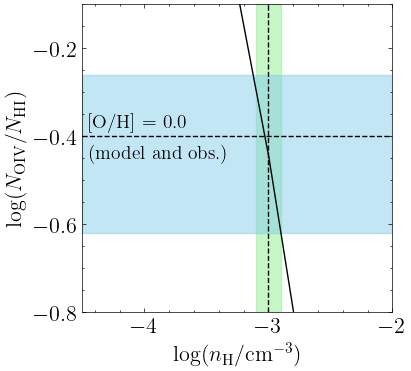

In [25]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=0)

ax.text(-4.45, -0.38, r'[O/H] = 0.0', fontsize=14)
ax.text(-4.45, -0.45, r'(model and obs.)', fontsize=14)

ax.axvline(-3.0, color='black', linestyle='--')
ax.axvspan(-3.0-0.1,-3.0+0.1, color='lightgreen', alpha=.5)

ax.axhline(-0.40, color='black', linestyle='--')
#ax.text(-4.4, -1.05, r'[O/H]=$-$0.1 (obs)', fontsize=14)

ax.axhspan(-0.40-0.22,-0.40+0.14, color='skyblue', alpha=.5)

ax.set_xlim(-4.5, -2.)

ax.set_ylim(-.8, -0.1)

ax.set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{HI})$')

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Figures/z_104_O_H.png', dpi=300)

## Two-phase solution

In [26]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O_p1, 'N':N_O_p1}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2, 'N':N_O_p2}])

    return log_prior_two_phase(params_full, species_logN_interp)
    
    #x = log_prior_two_phase(params_full, species_logN_interp)
    
    #if np.isfinite(x):  
        
        #logN_OIV_p1 = species_logN_interp['O+3']((logN_HI_test, log_hdens_p1, log_metals_p1))    
        #logN_OIV_p2 = species_logN_interp['O+3']((logN_HI_p2, log_hdens_p2, log_metals_p2))    
        
    #    logN_OV_p1 = species_logN_interp['O+4']((logN_HI_test, log_hdens_p1, log_metals_p1))    
    #    logN_OV_p2 = species_logN_interp['O+4']((logN_HI_p2, log_hdens_p2, log_metals_p2))    

    #    if logN_OV_p1<logN_OV_p2: #logN_OIV_p1>logN_OIV_p2 and :
    #        return x
    #    else:
    #        return -np.inf
    #else:
    #    return -np.inf

In [27]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O_p1, 'N':N_O_p1}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2, 'N':N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [28]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [29]:
logN_dict = {'HI':'14.9, -0.1, +0.2',
            #'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            'NIV':'13.01, -0.09, +0.09',
            'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV':'13.97, -0.03, +0.03',
            'OVI':'13.7, -0.2, +0.2',
            'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [30]:
logN_HI_test = 14.9
log_hdens_test_p1 = -3.0
log_metals_test_p1 = 0.1
C_O_test_p1 = -0.2
N_O_test_p1 = -0.5

logN_HI_test_p2 = 13.7
log_hdens_test_p2 = -4.2
log_metals_test_p2 = -0.7
C_O_test_p2 = -2.0
N_O_test_p2 = -2.0

In [31]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp, {'C':C_O_test_p1, 'N':N_O_test_p1}))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp, {'C':C_O_test_p2, 'N':N_O_test_p2}))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

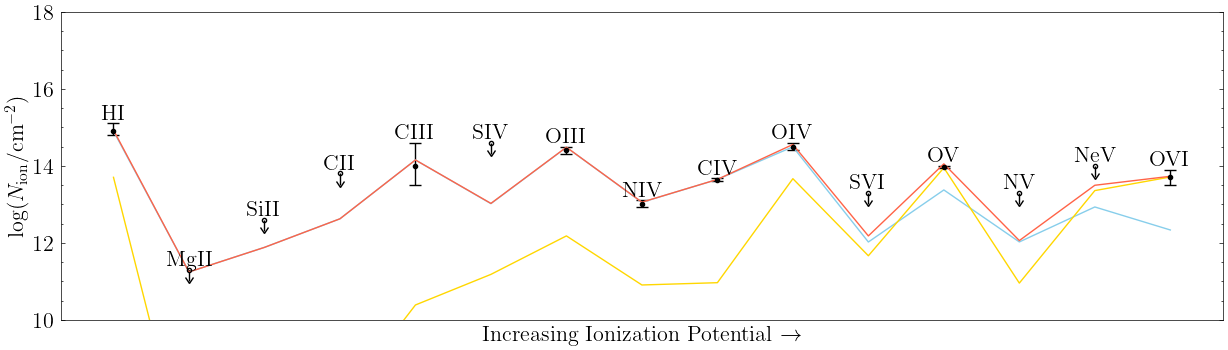

In [32]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='tomato')

In [33]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [34]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [35]:
#sampler.run_mcmc(pos, 1000, progress=True);

In [36]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'N_O_p1',
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c1.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c1.csv')

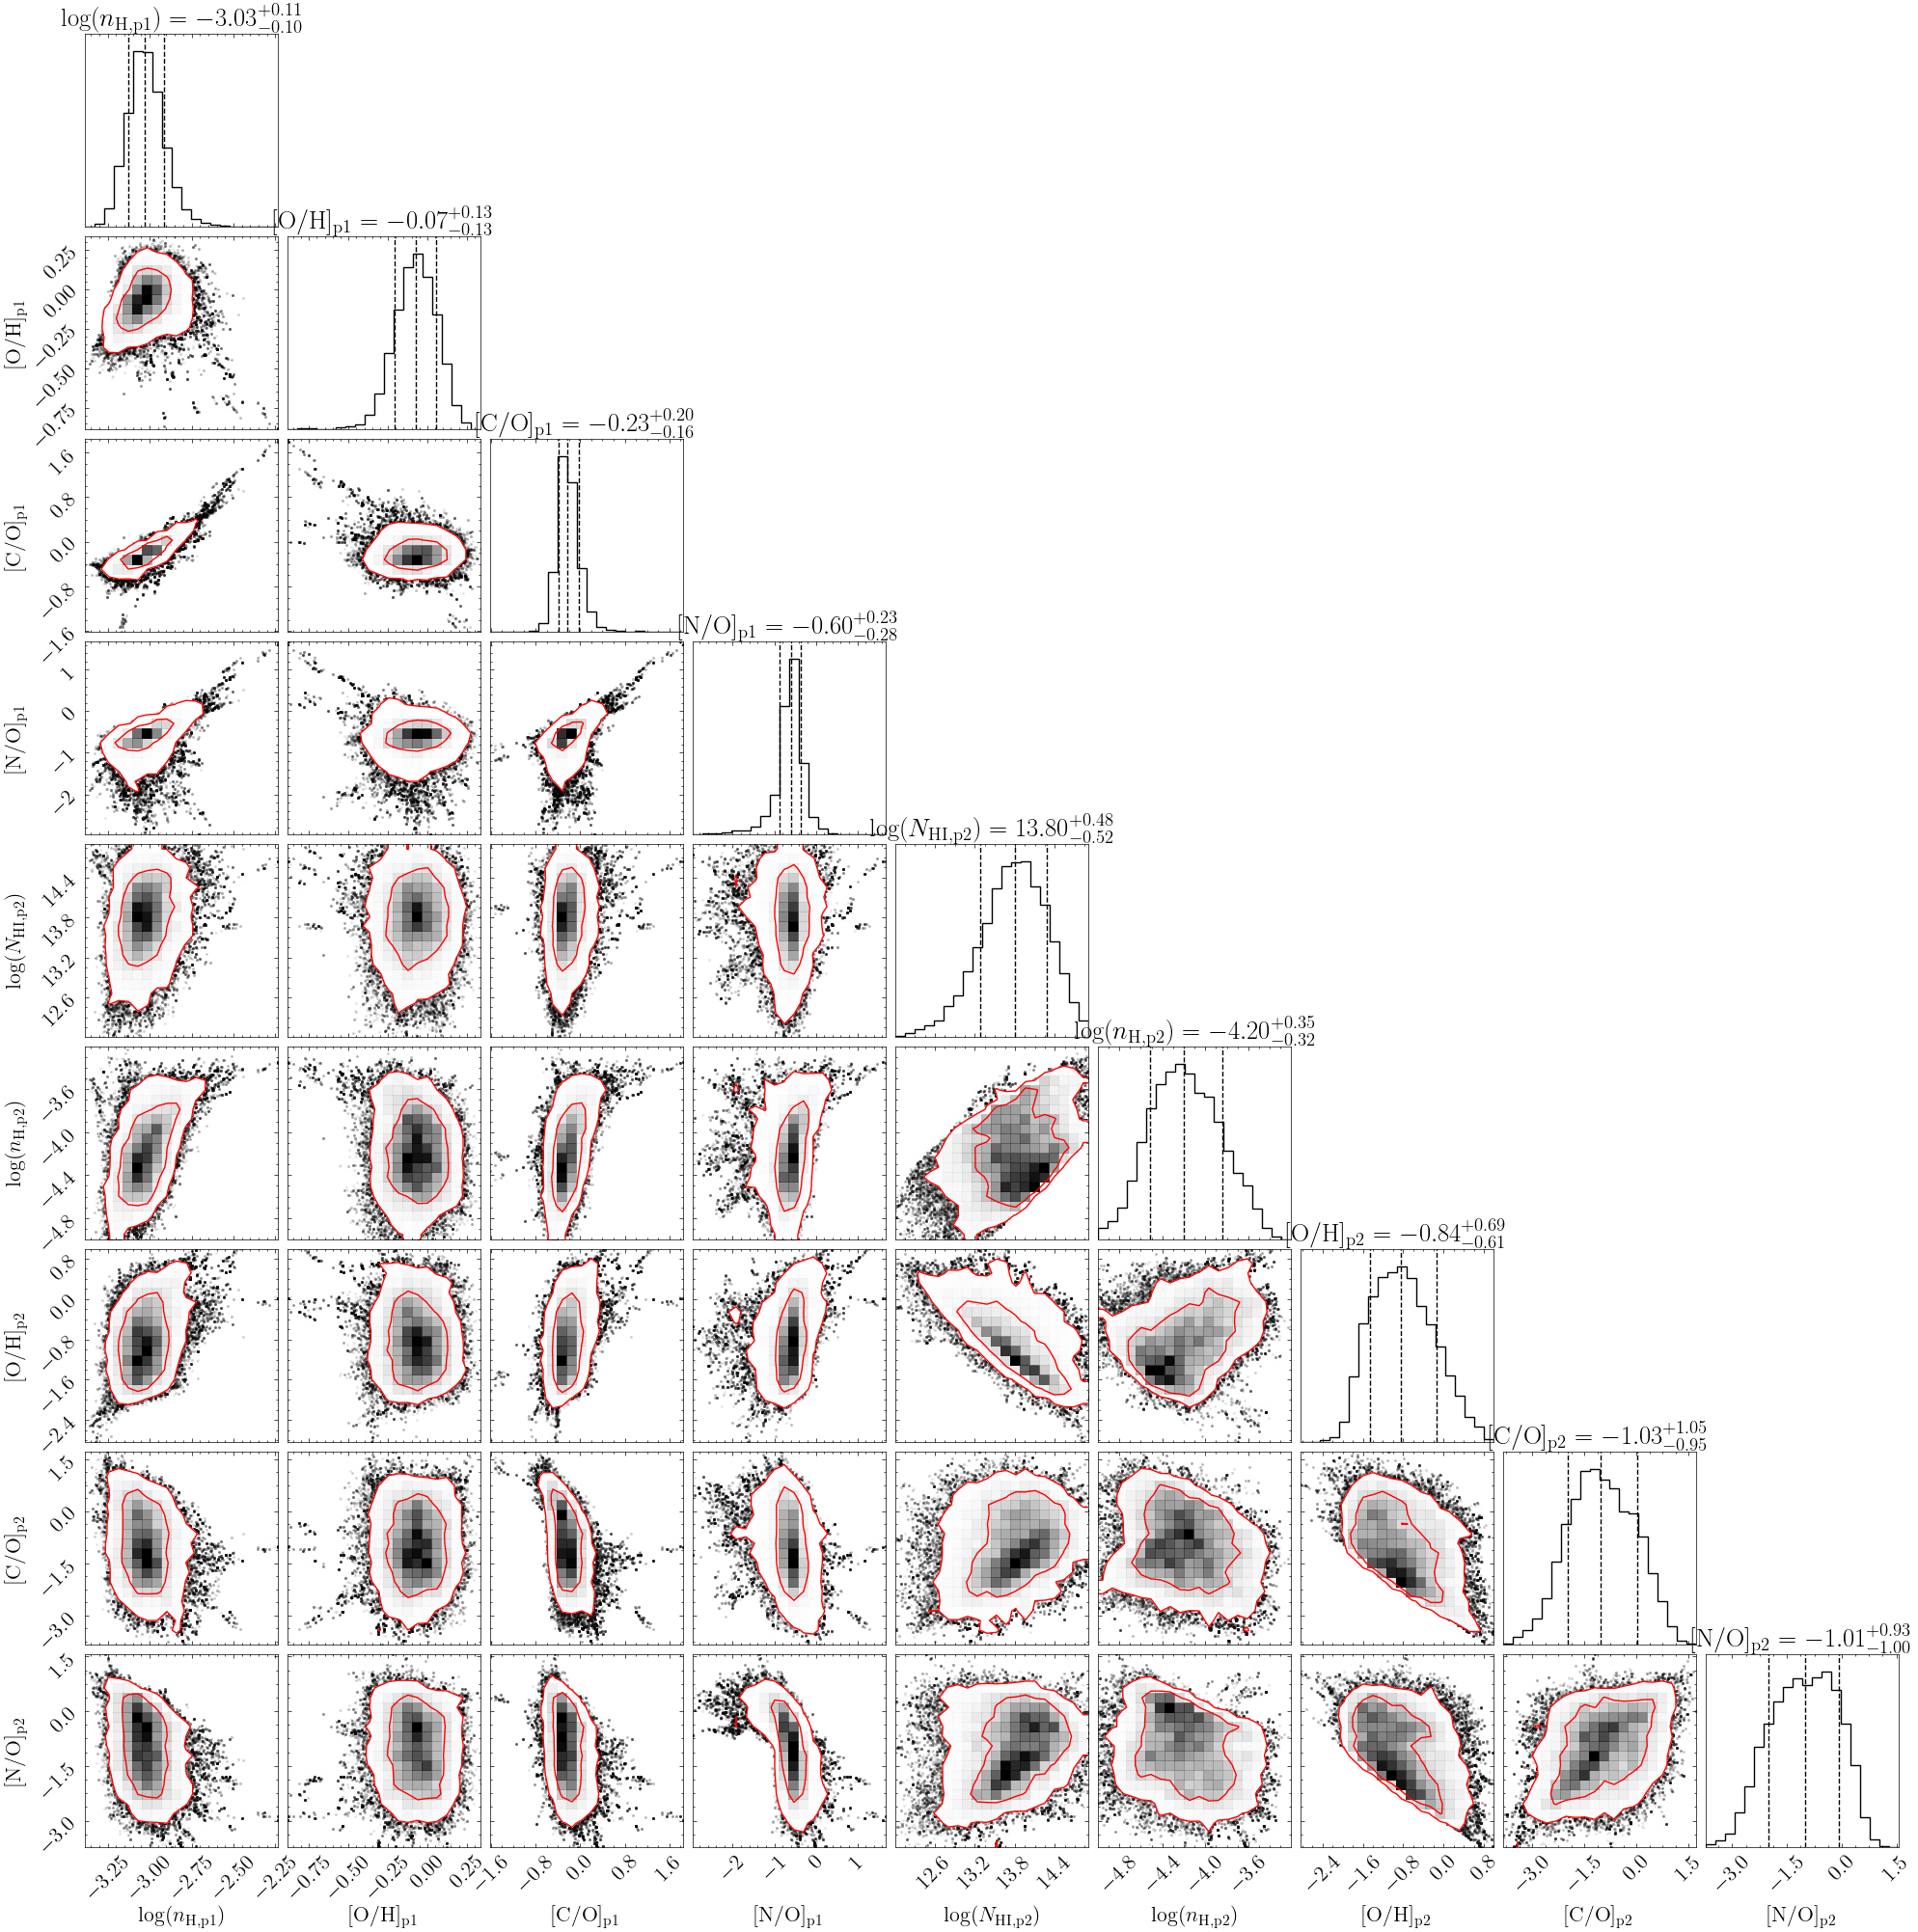

In [37]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{N/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
            r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [38]:
np.median(flat_samples_two_phase['log_metals_p1'])

-0.0704075001588049

In [39]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(12.19367151666435, 14.875765372009903)

In [40]:
np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*cdf_1sig)-np.median(flat_samples_two_phase['log_hdens_p2'])

0.35591211534238054

In [41]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-2.2855289067873024, 0.8107291137828613)

In [42]:
np.percentile(flat_samples_two_phase['C_O_p2'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p2'], 100*cdf_3sig)

(1.322378434901862, 1.0009153183125803)

Now plot the best models

In [43]:
logN_dict = {#'HI':'14.9, -0.1, +0.2',
            'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            'NIV':'13.01, -0.09, +0.09',
            'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV':'13.97, -0.03, +0.03',
            'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [44]:
b_dict = {'HI':'18, -2, +1',
          'HeI': '9.7, -0.8, +0.8',
          'CIII':'6.4, -0.4, +0.4',
          'CIV':'6.4, -0.4, +0.4',
          'NIV':'6.4, -0.4, +0.4',
          'OIII':'6.4, -0.4, +0.4',
          'OIV':'6.4, -0.4, +0.4',
          'OV':'23, -1, +1',
          'OVI':'23, -1, +1'}

In [45]:
z_sys = 1.04430762

In [46]:
import matplotlib.lines as mlines

In [47]:
# Best-fit model prediction

logN_species_p1_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples_two_phase['log_hdens_p1']), 
                                        np.median(flat_samples_two_phase['log_metals_p1']), 
                                        species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p1']), 
                                                              'N':np.median(flat_samples_two_phase['N_O_p1'])})

logN_species_p2_best = predict_col_dens(logN_dict, np.median(flat_samples_two_phase['logN_HI_p2']), 
                                        np.median(flat_samples_two_phase['log_hdens_p2']), 
                                        np.median(flat_samples_two_phase['log_metals_p2']), 
                                                 species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p2']), 'N':np.median(flat_samples_two_phase['N_O_p2'])})

logN_species_best = np.log10(10**logN_species_p1_best + 10**logN_species_p2_best)

In [48]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [49]:
logN_res_up = {k:'<1.1' for k in list(logN_res_dict.keys())}

#logN_res_up['CII'] = '<0.75'
logN_res_up['SVI'] = '<0.75'
logN_res_up['NV'] = '<0.75'

In [50]:
# Model curves for each step
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

In [51]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_p1_lo = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*(1-cdf_1sig))
log_hdens_p1_hi = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*cdf_1sig)

log_metals_p1_lo = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*(1-cdf_1sig))
log_metals_p1_hi = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_1sig)

C_O_p1_lo = np.percentile(flat_samples_two_phase['C_O_p1'], 100*(1-cdf_1sig))
C_O_p1_hi = np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_1sig)

N_O_p1_lo = np.percentile(flat_samples_two_phase['N_O_p1'], 100*(1-cdf_1sig))
N_O_p1_hi = np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_1sig)

log_hdens_p2_lo = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*(1-cdf_1sig))
log_hdens_p2_hi = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*cdf_1sig)

for i in range(len(flat_samples_two_phase)):
    log_hdens_p1 = flat_samples_two_phase['log_hdens_p1'][i]
    log_metals_p1 = flat_samples_two_phase['log_metals_p1'][i]
    C_O_p1 = flat_samples_two_phase['C_O_p1'][i]
    N_O_p1 = flat_samples_two_phase['N_O_p1'][i]
    log_hdens_p2 = flat_samples_two_phase['log_hdens_p2'][i]
    
    if log_hdens_p1_lo<log_hdens_p1<log_hdens_p1_hi and log_metals_p1_lo<log_metals_p1<log_metals_p1_hi and C_O_p1_lo<C_O_p1<C_O_p1_hi and N_O_p1_lo<N_O_p1<N_O_p1_hi and log_hdens_p2_lo<log_hdens_p2<log_hdens_p2_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

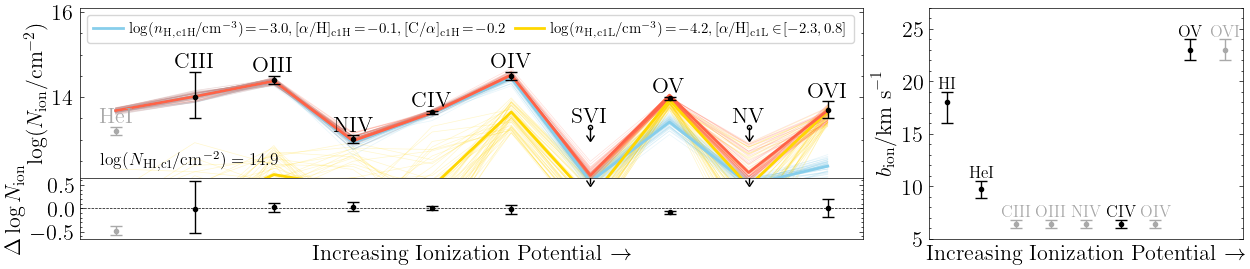

In [52]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_grid[:,filtered[idx]], color='skyblue', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_best, color='skyblue', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_best, color='gold', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

plot_column_densities_obs(logN_dict, fig, axd['upper left'], gray_out='HeI')


axd['upper left'].text(-0.2, 12.4, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.9$', fontsize=12.5,
            horizontalalignment='left')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) \!=\! -3.0, \mathrm{[\alpha/H]_{c1H}}\!=\!-0.1, \mathrm{[C/\alpha]_{c1H}}\!=\!-0.2$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) \!=\! -4.2, \mathrm{[\alpha/H]_{c1L}}\!\in\![-2.3,0.8]$'))
    
axd['upper left'].legend(handles=handles, loc='upper left', fontsize=10.7, ncol=2, columnspacing=.6, handletextpad=0.4)

axd['upper left'].set_ylim(12.1,16.1)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.15, gray_out=['HeI'])
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.15, gray_out=['HeI'])

axd['lower left'].set_ylim(-0.65,.65)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_linewidth_obs(b_dict, fig, axd['right'], fs=12, gray_out = ['CIII', 'OIII', 'NIV', 'OIV', 'OVI', 'NeV'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(5,27)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

## Presentation plot

In [77]:
logN_dict = {#'HI':'14.9, -0.1, +0.2',
            #'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            #'NIV':'13.01, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV':'13.97, -0.03, +0.03',
            'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [78]:
# Best-fit model prediction

logN_species_p1_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples_two_phase['log_hdens_p1']), 
                                        np.median(flat_samples_two_phase['log_metals_p1']), 
                                        species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p1']), 
                                                              'N':np.median(flat_samples_two_phase['N_O_p1'])})

logN_species_p2_best = predict_col_dens(logN_dict, np.median(flat_samples_two_phase['logN_HI_p2']), 
                                        np.median(flat_samples_two_phase['log_hdens_p2']), 
                                        np.median(flat_samples_two_phase['log_metals_p2']), 
                                                 species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p2']), 'N':np.median(flat_samples_two_phase['N_O_p2'])})

logN_species_best = np.log10(10**logN_species_p1_best + 10**logN_species_p2_best)

In [79]:
# Model curves for each step
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

In [80]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_p1_lo = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*(1-cdf_1sig))
log_hdens_p1_hi = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*cdf_1sig)

log_metals_p1_lo = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*(1-cdf_1sig))
log_metals_p1_hi = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_1sig)

C_O_p1_lo = np.percentile(flat_samples_two_phase['C_O_p1'], 100*(1-cdf_1sig))
C_O_p1_hi = np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_1sig)

N_O_p1_lo = np.percentile(flat_samples_two_phase['N_O_p1'], 100*(1-cdf_1sig))
N_O_p1_hi = np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_1sig)

log_hdens_p2_lo = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*(1-cdf_1sig))
log_hdens_p2_hi = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*cdf_1sig)

for i in range(len(flat_samples_two_phase)):
    log_hdens_p1 = flat_samples_two_phase['log_hdens_p1'][i]
    log_metals_p1 = flat_samples_two_phase['log_metals_p1'][i]
    C_O_p1 = flat_samples_two_phase['C_O_p1'][i]
    N_O_p1 = flat_samples_two_phase['N_O_p1'][i]
    log_hdens_p2 = flat_samples_two_phase['log_hdens_p2'][i]
    
    if log_hdens_p1_lo<log_hdens_p1<log_hdens_p1_hi and log_metals_p1_lo<log_metals_p1<log_metals_p1_hi and C_O_p1_lo<C_O_p1<C_O_p1_hi and N_O_p1_lo<N_O_p1<N_O_p1_hi and log_hdens_p2_lo<log_hdens_p2<log_hdens_p2_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

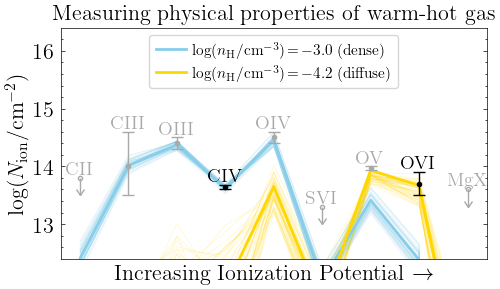

In [92]:
fig, ax = plt.subplots(1, figsize=(5.5,3.))

for idx in plot_idx:
    ax.plot(np.arange(len(logN_dict)), logN_species_p1_grid[:,filtered[idx]], color='skyblue', lw=.5, alpha=.2)
    ax.plot(np.arange(len(logN_dict)), logN_species_p2_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
#    ax.plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
ax.plot(np.arange(len(logN_dict)), logN_species_p1_best, color='skyblue', lw=2)
ax.plot(np.arange(len(logN_dict)), logN_species_p2_best, color='gold', lw=2)
#ax.plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)
   

plot_column_densities_obs(logN_dict, fig, ax, c_dy=1.5, gray_out=['CII','CIII', 'OIV', 'OIII', 'NIV', 'SVI', 'NV','OV','MgX'], fs=14)

#ax.text(-0.2, 12.4, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.9$', fontsize=12.5,
#            horizontalalignment='left')

ax.set_ylim(12.4,16.4)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H}/\mathrm{cm}^{-3}) \!=\! -3.0$ (dense)'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H}/\mathrm{cm}^{-3}) \!=\! -4.2$ (diffuse)'))
     
ax.legend(handles=handles, loc='upper center', fontsize=11, ncol=1, columnspacing=.6, handletextpad=0.4)

ax.set_title('Measuring physical properties of warm-hot gas', fontsize=16)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_no_lw.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_no_lw.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

Get cloud sizes

In [46]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

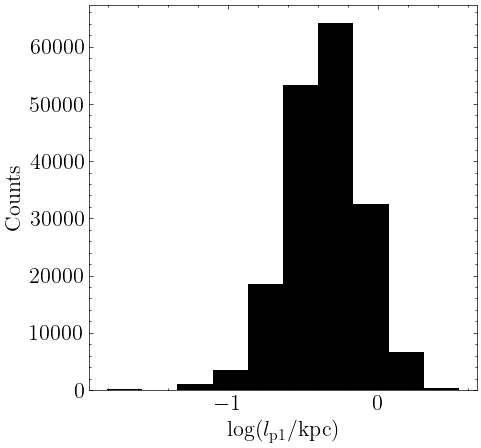

In [47]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [48]:
get_quantiles(np.log10(l_p1))

-0.35 -0.25 0.25


In [49]:
np.median(np.log10(l_p1))

-0.3500976383119804

In [50]:
np.percentile(np.log10(l_p1), 100*cdf_1sig)-np.median(np.log10(l_p1))

0.2456038385130722

In [51]:
np.median(np.log10(l_p1))-np.percentile(np.log10(l_p1), 100*(1-cdf_1sig))

0.24573180818731222

Text(0, 0.5, 'Counts')

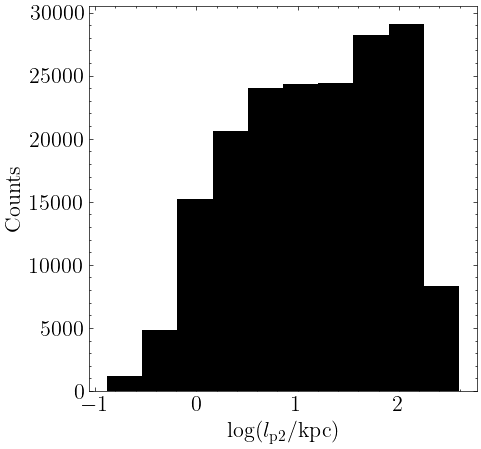

In [52]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [53]:
get_quantiles(np.log10(l_p2))

1.2 -0.92 0.8


In [54]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(-0.6935689528951555, 2.4832607324816136)

# c2

## Column density ratios

In [55]:
logN_dict = {'HI':'13.9, -0.2, +0.2',
            'HeI':'13.1, -0.2, +0.1',
            'CII':'<13.8',
            'CIII':'13.1, -0.5, +0.4',
            'CIV':'13.41, -0.02, +0.02',
            'NIV':'12.9, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.9, -0.1, +0.1',
            'OIV':'14.21, -0.07, +0.07',
            'OV ':'13.6, -0.2, +0.2',
            'OVI':'<13.8',
            'NeV':'<14.0',
            'MgII':'<11.3',
            'MgX':'<13.6',
            'AlII':'<11.1',
            'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',
            'FeII':'<11.6',}

In [56]:
gen_logN_ratio_str(logN_dict['HeI'], logN_dict['HI'])

'-0.80, -0.28, 0.22'

In [57]:
logN_ratio_dict = {'OIV/OIII': '0.32, -0.12, 0.12',
                   'OV/OIV': '-0.62, -0.21, 0.21',
                  'CIV/CIII': '0.07, -0.40, 0.40'}

(-2.2, 2.5)

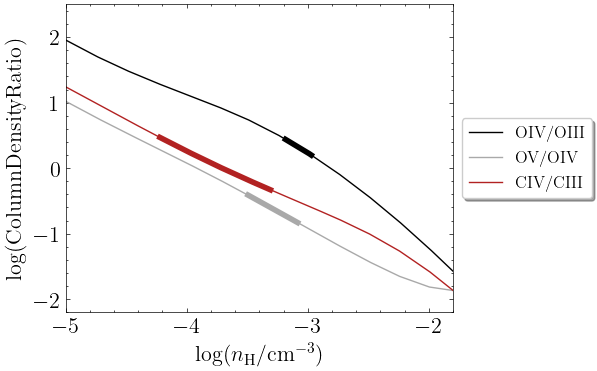

In [58]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2.5)

## Single phase solution

In [262]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [263]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [264]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [265]:
logN_dict = {#'HI':'13.9, -0.2, +0.2',
            #'HeI':'13.1, -0.2, +0.1',
            'CII':'<13.8',
            'CIII':'13.1, -0.5, +0.4',
            'CIV':'13.41, -0.02, +0.02',
            'NIV':'12.9, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.9, -0.1, +0.1',
            'OIV':'14.21, -0.07, +0.07',
            'OV':'13.6, -0.2, +0.2',
            'OVI':'<13.8',
            'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [266]:
logN_HI_test = 13.9
log_hdens_test = -3.3
log_metals_test = 0.4
C_O_test = -0.2
N_O_test = -0.4

In [267]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test,
                                                                                                                              'N':N_O_test})

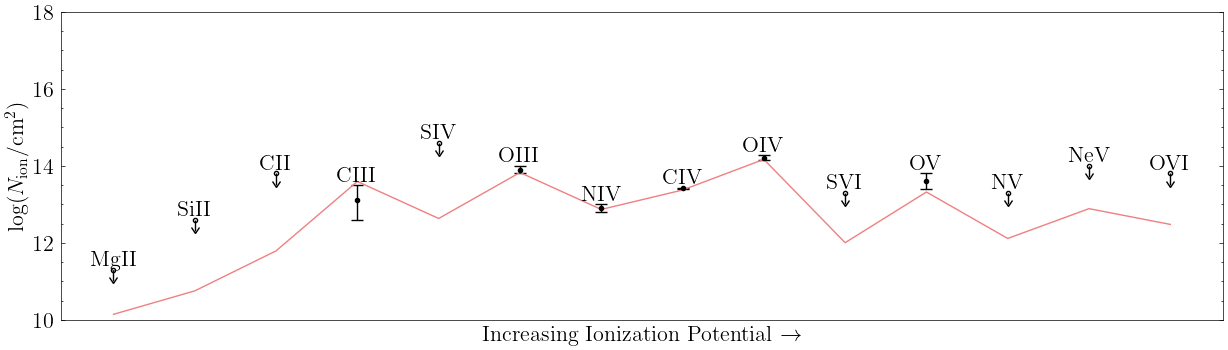

In [268]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [269]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [270]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [271]:
#sampler.run_mcmc(pos, 500, progress=True);

In [272]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'one_phase_c2.csv', index=False)

flat_samples = pd.read_csv(savedir+'one_phase_c2.csv')

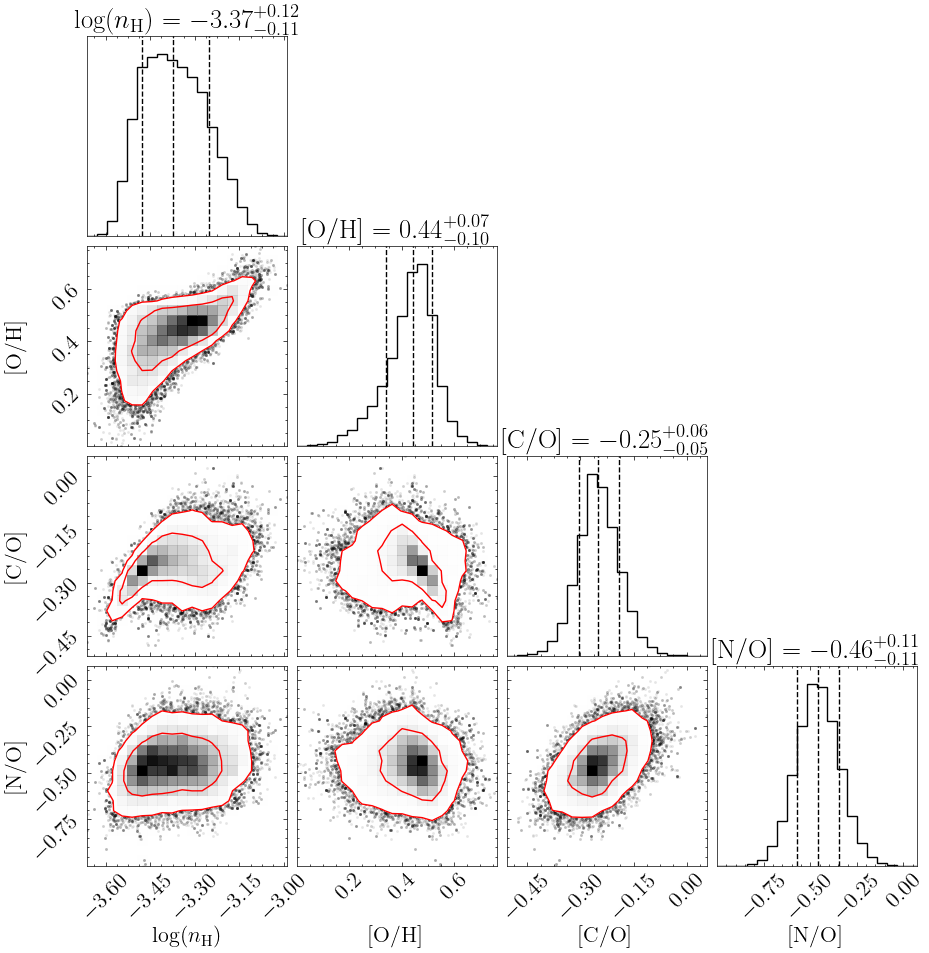

In [273]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$', r'$[\mathrm{N/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [274]:
np.median(flat_samples['C_O'])

-0.25048338704676687

Now plot the best models

In [275]:
logN_dict = {#'HI':'13.9, -0.2, +0.2',
            'HeI':'13.1, -0.2, +0.1',
            #'CII':'<13.8',
            'CIII':'13.1, -0.5, +0.4',
            'CIV':'13.41, -0.02, +0.02',
            'NIV':'12.9, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.9, -0.1, +0.1',
            'OIV':'14.21, -0.07, +0.07',
            'OV':'13.6, -0.2, +0.2',
            'OVI':'<13.8',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [276]:
b_dict = {'HI':'11, -2, +2',
          'HeI': '8, -1, +2',
          'CIII':'6.1, -0.5, +0.5',
          'CIV':'6.1, -0.5, +0.5',
          'NIV':'6.1, -0.5, +0.5',
          'OIII':'6.1, -0.5, +0.5',
          'OIV':'6.1, -0.5, +0.5',
          'OV':'6.1, -0.5, +0.5'}

In [277]:
z_sys = 1.04430762

In [278]:
import matplotlib.lines as mlines

In [279]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [280]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [281]:
logN_res_up = {k:'<0.9' for k in list(logN_res_dict.keys())}

logN_res_up['HeI'] = '<0.45'
logN_res_up['SVI'] = '<0.45'
logN_res_up['NV'] = '<0.45'
logN_res_up['OVI'] = '<0.45'

In [282]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [283]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

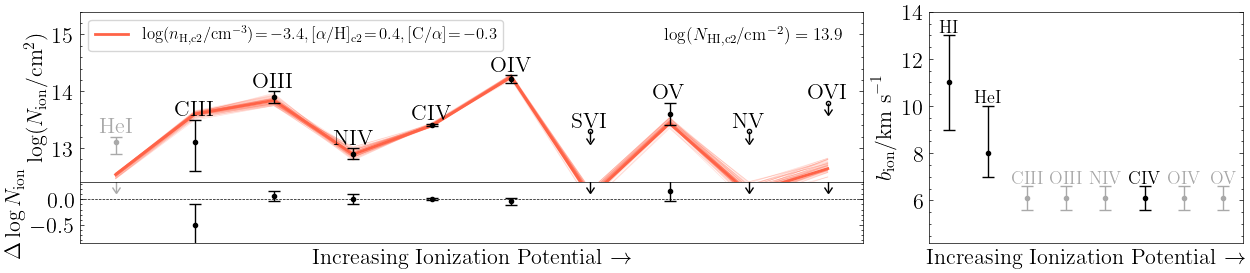

In [286]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

plot_column_densities_obs(logN_dict, fig, axd['upper left'], dy=.12, c_dy=1.7, gray_out=['HeI'])

axd['upper left'].set_ylim(12.4,15.4)

axd['upper left'].text(len(logN_dict)-.8, 14.9, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 13.9$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2}/\mathrm{cm}^{-3}) \!=\! -3.4, \mathrm{[\alpha/H]_{c2}}\!=\!0.4, \mathrm{[C/\alpha]}\!=\!-0.3$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], gray_out=['HeI'], label_ions=False)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], gray_out=['HeI'], label_ions=False)

axd['lower left'].set_ylim(-0.85,.34)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIII', 'NIV', 'OIV', 'OV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(4.2,14)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c2.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [99]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

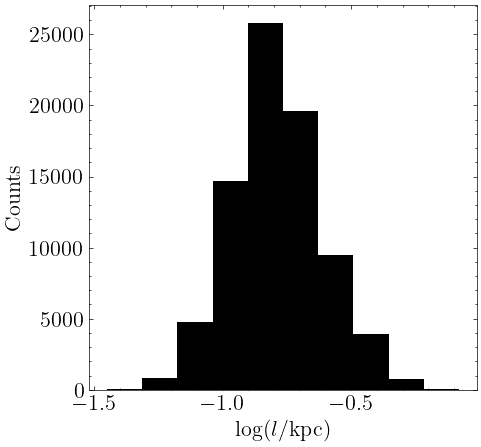

In [100]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [101]:
get_quantiles(np.log10(l))

-0.8 -0.15 0.19


# c3

## Column density ratios

In [102]:
logN_dict = {'HI':'14.3, -0.2, +0.1',
            'HeI':'<13.1',
            'CII':'<13.8',
            'CIII':'13.9, -0.4, +0.3',
            'CIV':'13.40, -0.04, +0.04',
            'NIV':'13.0, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.59, -0.06, +0.06',
            'OIV':'14.29, -0.06, +0.06',
            'OV':'14.34, -0.08, +0.08',
            'OVI':'14.0, -0.1, +0.1',
            'NeV':'<14.0',
            'MgII':'<11.3',
            'MgX':'<13.6',
            'AlII':'<11.1',
            'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',
            'FeII':'<11.6',}

In [103]:
gen_logN_ratio_str(logN_dict['OVI'], logN_dict['OIV'])

'-0.29, -0.12, 0.12'

In [104]:
logN_ratio_dict = {'CIV/CIII': '-0.55, -0.30, 0.20',
                    'OIV/OIII': '0.74, -0.11, 0.09',
                   'OVI/OV': '-0.37, -0.11, 0.13', #'<-0.3, 0.3', 
                   'NeV/OVI': '<0.0, 0.2',
                   #'SVI/OVI': '<-0.70, 0.16',
                   'OVI/OIV': '-0.30, -0.10, 0.10',
                  }

In [105]:
z_sys=1.04430803

(-2.2, 2.5)

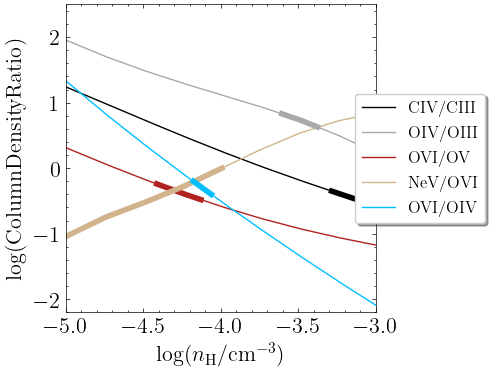

In [106]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -3)
ax.set_ylim(-2.2, 2.5)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_frac.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

## Two-phase solution

In [107]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O_p1, 'N':N_O_p1}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2, 'N':N_O_p2}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [108]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O_p1, 'N':N_O_p1}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2, 'N':N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [109]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [110]:
logN_dict = {'HI':'14.3, -0.2, +0.1',
            'HeI':'<13.1',
            'CII':'<13.8',
            #'CIII':'13.9, -0.4, +0.3',
            'CIV':'13.40, -0.04, +0.04',
            'NIV':'13.0, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.59, -0.06, +0.06',
            'OIV':'14.29, -0.06, +0.06',
            'OV':'14.34, -0.08, +0.08',
            'OVI':'14.0, -0.1, +0.1',
            'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [111]:
logN_HI_test = 14.3
log_hdens_test_p1 = -3.4
log_metals_test_p1 = -0.3
C_O_test_p1 = -0.2
N_O_test_p1 = -0.4

logN_HI_test_p2 = 13.7
log_hdens_test_p2 = -4.3
log_metals_test_p2 = -0.5
C_O_test_p2 = -2.0
N_O_test_p2 = -2.0

In [112]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp, {'C':C_O_test_p1, 'N':N_O_test_p1}))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp, {'C':C_O_test_p2, 'N':N_O_test_p2}))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

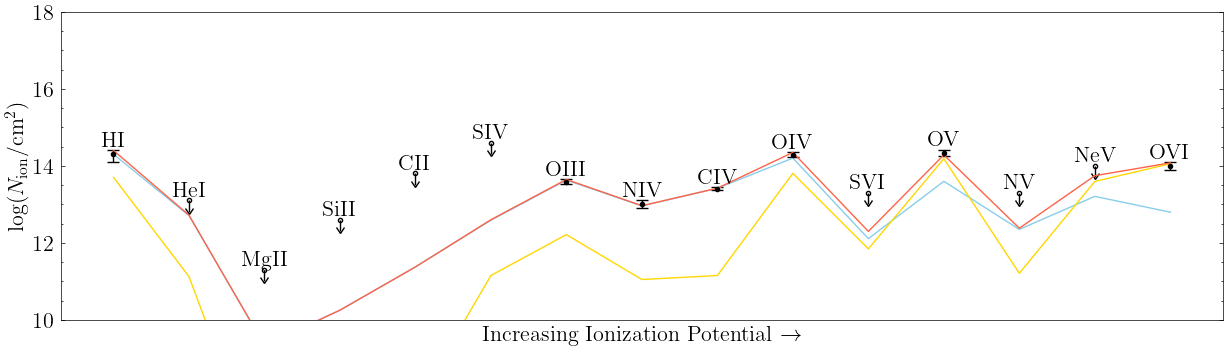

In [113]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='tomato')

In [114]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [115]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [116]:
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [06:59<00:00,  2.38it/s]


In [117]:
flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'N_O_p1',
                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
flat_samples_two_phase.to_csv(savedir+'two_phase_c3.csv', index=False)

#flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c3.csv')

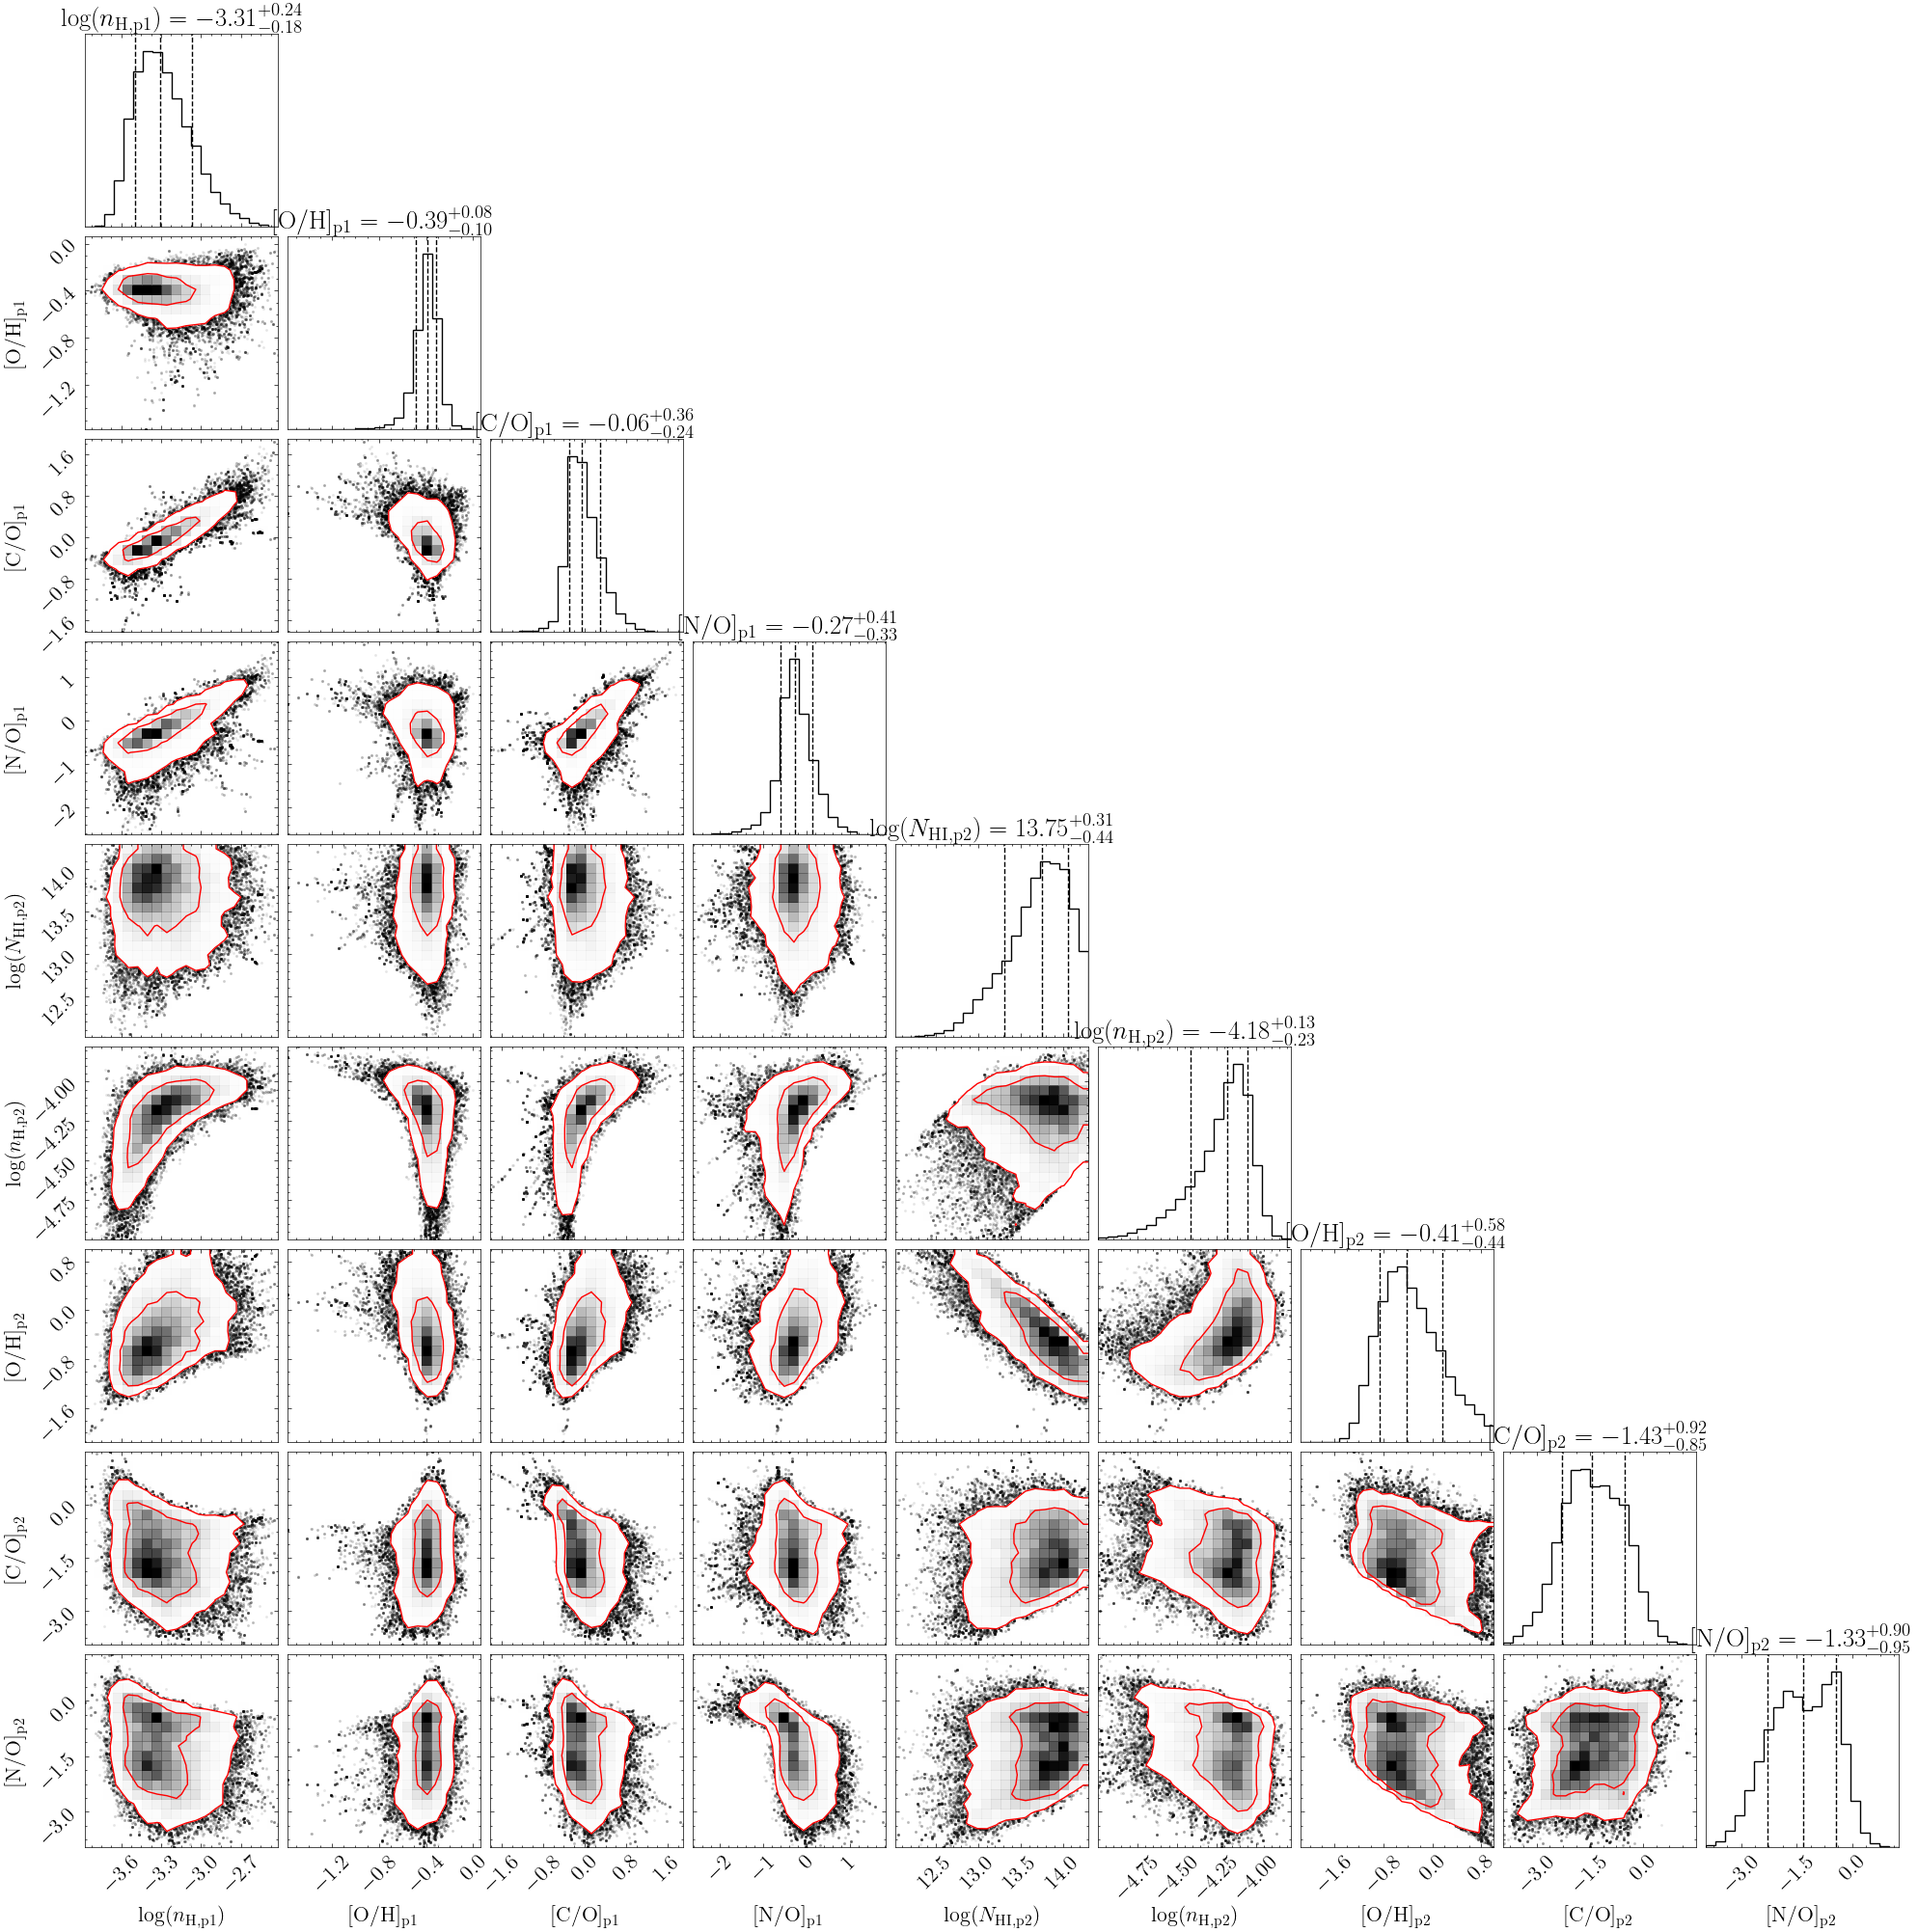

In [118]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{N/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
            r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [123]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(12.3859209250784, 14.297692328376622)

In [124]:
np.median(flat_samples_two_phase['log_hdens_p2'])

-4.180175422197678

In [125]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-1.4324011659786933, 0.9742199406997114)

In [126]:
np.percentile(flat_samples_two_phase['C_O_p2'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p2'], 100*cdf_3sig)

(0.8281840551675632, 0.5779325985690095)

Now plot the best models

In [127]:
logN_dict = {#'HI':'14.3, -0.2, +0.1',
            'HeI':'<13.1',
            #'CII':'<13.8',
            'CIII':'13.9, -0.4, +0.3',
            'CIV':'13.40, -0.04, +0.04',
            'NIV':'13.0, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.59, -0.06, +0.06',
            'OIV':'14.29, -0.06, +0.06',
            'OV':'14.34, -0.08, +0.08',
            'OVI':'14.0, -0.1, +0.1',
            'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [130]:
b_dict = {'HI':'13, -2, +3',
          'CIII':'10, -1, +1',
          'CIV':'10, -1, +1',
          'NIV':'10, -1, +1',
          'OIII':'10, -1, +1',
          'OIV':'10, -1, +1',
          'OV':'26, -2, +2',
          'OVI':'26, -2, +2'}

In [131]:
z_sys = 1.04430762

In [132]:
import matplotlib.lines as mlines

In [133]:
# Best-fit model prediction

logN_species_p1_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples_two_phase['log_hdens_p1']), 
                                        np.median(flat_samples_two_phase['log_metals_p1']), 
                                        species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p1']), 
                                                              'N':np.median(flat_samples_two_phase['N_O_p1'])})

logN_species_p2_best = predict_col_dens(logN_dict, np.median(flat_samples_two_phase['logN_HI_p2']), 
                                        np.median(flat_samples_two_phase['log_hdens_p2']), 
                                        np.median(flat_samples_two_phase['log_metals_p2']), 
                                                 species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p2']), 
                                                                       'N':np.median(flat_samples_two_phase['N_O_p2'])})

logN_species_best = np.log10(10**logN_species_p1_best + 10**logN_species_p2_best)

In [134]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [135]:
logN_res_up = {k:'<1.1' for k in list(logN_res_dict.keys())}

#logN_res_up['CII'] = '<0.75'
logN_res_up['SVI'] = '<0.7'
#logN_res_up['NV'] = '<0.75'

In [136]:
# Model curves for each step
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

In [137]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_p1_lo = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*(1-cdf_1sig))
log_hdens_p1_hi = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*cdf_1sig)

log_metals_p1_lo = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*(1-cdf_1sig))
log_metals_p1_hi = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_1sig)

C_O_p1_lo = np.percentile(flat_samples_two_phase['C_O_p1'], 100*(1-cdf_1sig))
C_O_p1_hi = np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_1sig)

N_O_p1_lo = np.percentile(flat_samples_two_phase['N_O_p1'], 100*(1-cdf_1sig))
N_O_p1_hi = np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_1sig)

log_hdens_p2_lo = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*(1-cdf_1sig))
log_hdens_p2_hi = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*cdf_1sig)

for i in range(len(flat_samples_two_phase)):
    log_hdens_p1 = flat_samples_two_phase['log_hdens_p1'][i]
    log_metals_p1 = flat_samples_two_phase['log_metals_p1'][i]
    C_O_p1 = flat_samples_two_phase['C_O_p1'][i]
    N_O_p1 = flat_samples_two_phase['N_O_p1'][i]
    log_hdens_p2 = flat_samples_two_phase['log_hdens_p2'][i]
    
    if log_hdens_p1_lo<log_hdens_p1<log_hdens_p1_hi and log_metals_p1_lo<log_metals_p1<log_metals_p1_hi and C_O_p1_lo<C_O_p1<C_O_p1_hi and N_O_p1_lo<N_O_p1<N_O_p1_hi and log_hdens_p2_lo<log_hdens_p2<log_hdens_p2_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

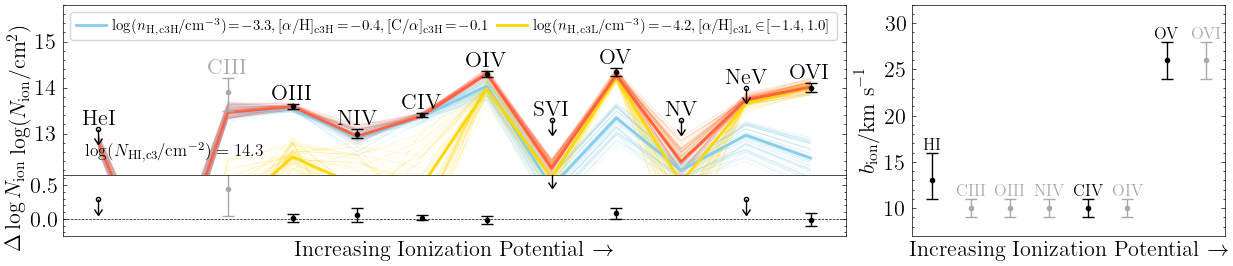

In [139]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_grid[:,filtered[idx]], color='skyblue', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_best, color='skyblue', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_best, color='gold', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)


plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                         gray_out = ['CIII'])


axd['upper left'].text(-0.2, 12.5, r'$\log(N_\mathrm{HI, c3}/\mathrm{cm}^{-2}) = 14.3$', fontsize=12.5,
            horizontalalignment='left')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c3H}/\mathrm{cm}^{-3}) \!=\! -3.3, \mathrm{[\alpha/H]_{c3H}}\!=\!-0.4, \mathrm{[C/\alpha]_{c3H}}\!=\!-0.1$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c3L}/\mathrm{cm}^{-3}) \!=\! -4.2, \mathrm{[\alpha/H]_{c3L}}\!\in\![-1.4,1.0]$'))
    
axd['upper left'].legend(handles=handles, loc='upper left', fontsize=10.7, ncol=2, columnspacing=.6, handletextpad=0.4)

axd['upper left'].set_ylim(12.1,15.8)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],
                         gray_out = ['CIII'], label_ions=False, dy=.15)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],
                         gray_out = ['CIII'], label_ions=False, dy=.15)

axd['lower left'].set_ylim(-0.25,.65)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_linewidth_obs(b_dict, fig, axd['right'], fs=12, gray_out = ['CIII', 'OIII', 'NIV', 'OIV', 'OVI', 'NeV'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(7,32)


plt.subplots_adjust(wspace=0.12, hspace=0)   

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c3.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c3.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

Get cloud sizes

In [140]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

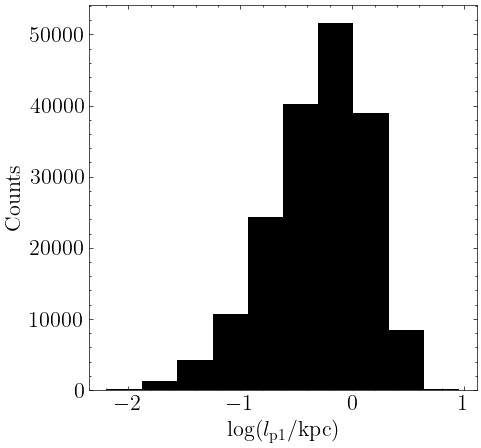

In [141]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [142]:
get_quantiles(np.log10(l_p1))

-0.25 -0.51 0.39


In [146]:
np.median(np.log10(l_p1))

-0.246181525938785

Text(0, 0.5, 'Counts')

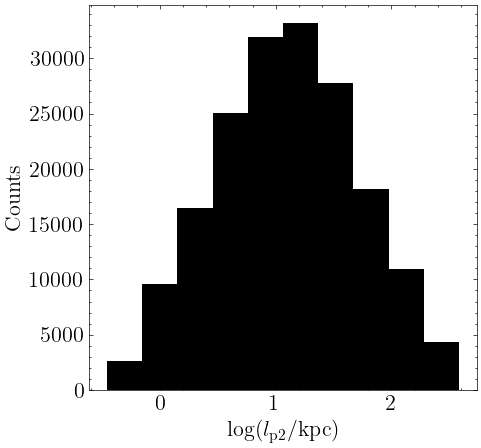

In [147]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [148]:
get_quantiles(np.log10(l_p2))

1.1 -0.65 0.64


In [149]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(-0.3249641341936042, 2.4836949128231054)

# c4

In [179]:
logN_dict = {'HI':'14.6, -0.1, +0.2',
            'HeI':'<13.1',
            'CII':'<13.8',
            'CIII':'13.2, -0.3, +0.3',
            'CIV':'13.52, -0.03, +0.03',
            'NIV':'12.9, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.60, -0.07, +0.07',
            'OIV':'13.9, -0.1, +0.1',
            'OV':'14.1, -0.4, +0.5',
            'OVI':'<13.8',
            'NeV':'<14.0',
            'MgII':'<11.3',
            'MgX':'<13.6',
            'AlII':'<11.1',
            'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',
            'FeII':'<11.6',}

## Column density ratios

In [180]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['CIII'])

'0.32, -0.30, 0.30'

In [181]:
logN_ratio_dict = {'CIV/CIII': '0.32, -0.30, 0.30',
    'OIV/OIII': '0.30, -0.12, 0.12',
       'OV/OIV':'0.20, -0.41, 0.51'}

(-2.2, 2.5)

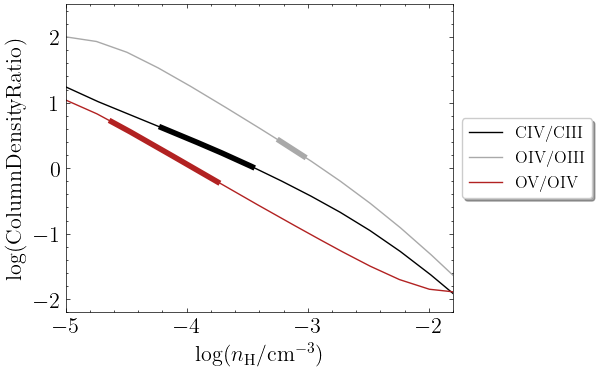

In [184]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, log_metals_ref=-0.5)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2.5)

## Single phase solution

In [301]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [302]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [303]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [304]:
logN_dict = {#'HI':'14.6, -0.1, +0.2',
            'HeI':'<13.1',
            'CII':'<13.8',
            #'CIII':'13.2, -0.3, +0.3',
            'CIV':'13.52, -0.03, +0.03',
            'NIV':'12.9, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.60, -0.07, +0.07',
            'OIV':'13.9, -0.1, +0.1',
            'OV':'14.1, -0.4, +0.5',
            'OVI':'<13.8',
            'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [305]:
logN_HI_test = 14.6
log_hdens_test = -3.5
log_metals_test = -0.3
C_O_test = 0.1
N_O_test = -0.3

In [306]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test,
                                                                                                                              'N':N_O_test})

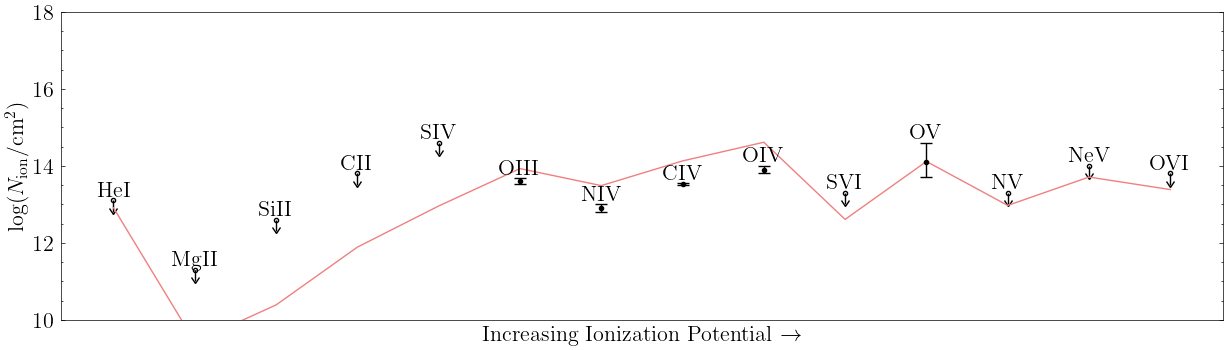

In [307]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [308]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [309]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [310]:
#sampler.run_mcmc(pos, 500, progress=True);

In [311]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'one_phase_c4.csv', index=False)

flat_samples = pd.read_csv(savedir+'one_phase_c4.csv')

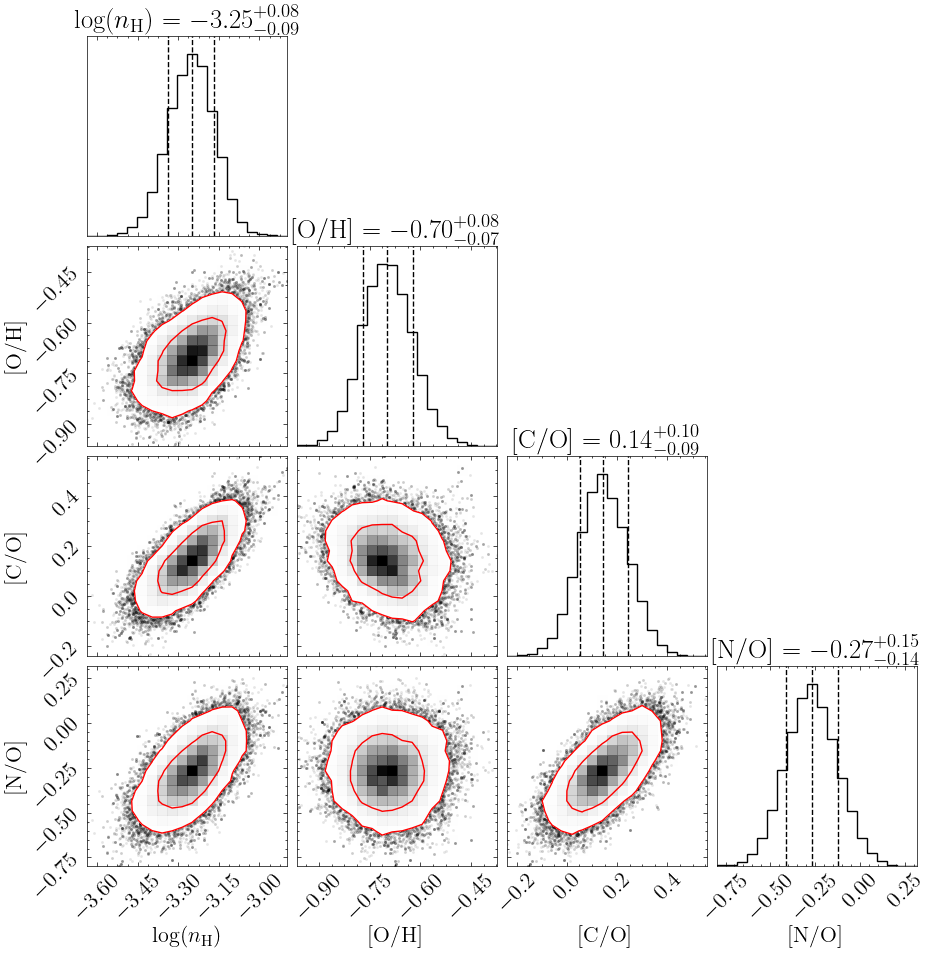

In [312]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$', r'$[\mathrm{N/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [313]:
np.percentile(flat_samples['N_O'], 100*cdf_1sig)-np.median(flat_samples['N_O'])

0.14602535827191748

In [314]:
np.median(flat_samples['log_hdens']), np.median(flat_samples['C_O'])

(-3.250460527202084, 0.14468703493258406)

Now plot the best models

In [315]:
logN_dict = {#'HI':'14.6, -0.1, +0.2',
            'HeI':'<13.1',
            #'CII':'<13.8',
            'CIII':'13.2, -0.3, +0.3',
            'CIV':'13.52, -0.03, +0.03',
            'NIV':'12.9, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.60, -0.07, +0.07',
            'OIV':'13.9, -0.1, +0.1',
            'OV':'14.1, -0.4, +0.5',
            'OVI':'<13.8',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [316]:
b_dict = {'HI':'21, -5, +6',
          'CIII':'8.2, -0.6, +0.6',
          'CIV':'8.2, -0.6, +0.6',
          'NIV':'8.2, -0.6, +0.6',
          'OIII':'8.2, -0.6, +0.6',
          'OIV':'8.2, -0.6, +0.6',
          'OV':'8.2, -0.6, +0.6'}

In [317]:
z_sys = 1.04430762

In [318]:
import matplotlib.lines as mlines

In [319]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [320]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [321]:
logN_res_up = {k:'<1.3' for k in list(logN_res_dict.keys())}

logN_res_up['SVI'] = '<0.45'
logN_res_up['NV'] = '<0.45'
logN_res_up['OVI'] = '<0.45'

In [322]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [323]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [324]:
logN_res_dict

{'HeI': '<0.0',
 'CIII': '-0.53, -0.3, 0.3',
 'OIII': '0.03, -0.07, 0.07',
 'NIV': '-0.01, -0.1, 0.1',
 'CIV': '-0.01, -0.03, 0.03',
 'OIV': '-0.13, -0.1, 0.1',
 'SVI': '<1.6',
 'OV': '0.78, -0.4, 0.5',
 'NV': '<1.2',
 'OVI': '<1.4'}

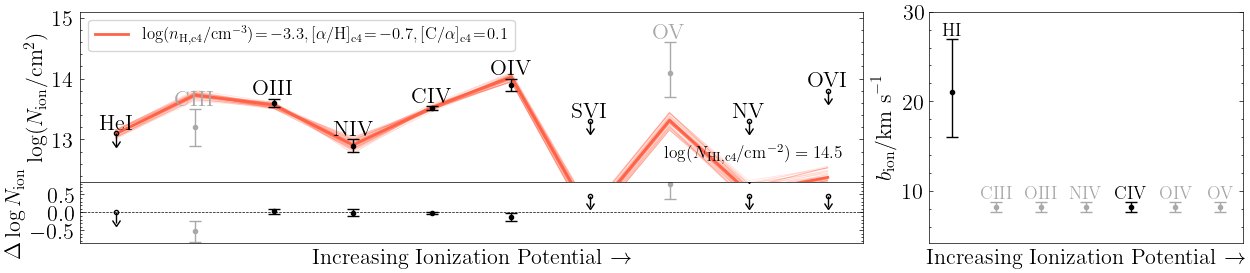

In [325]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)
    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], dy=.12, c_dy=1.7, gray_out=['CIII','OV'])

axd['upper left'].set_ylim(12.3,15.1)

axd['upper left'].text(len(logN_dict)-.8, 12.7, r'$\log(N_\mathrm{HI, c4}/\mathrm{cm}^{-2}) = 14.5$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c4}/\mathrm{cm}^{-3}) \!=\! -3.3, \mathrm{[\alpha/H]_{c4}} \!=\! -0.7, \mathrm{[C/\alpha]_{c4}}\!=\!0.1$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, gray_out=['CIII','OV'])
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, gray_out=['CIII','OV'])

axd['lower left'].set_ylim(-0.85,.85)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIII', 'NIV', 'OIV', 'OV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(4.2,30)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c4.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [259]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

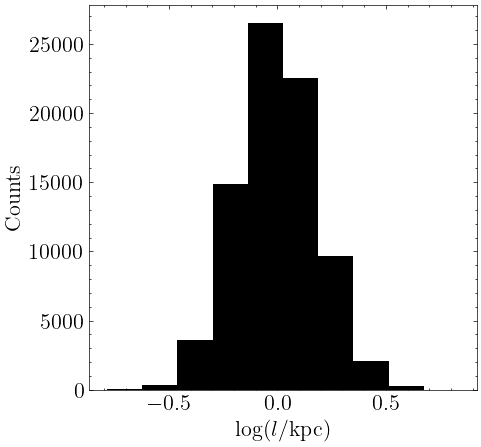

In [260]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [261]:
get_quantiles(np.log10(l))

-0.01 -0.18 0.19
